# Flatiron School DS-Flex Phase Three Milestone

## Business Case Overview

<img src=./images/Header.png>

### The Company

Sigma Airlines is the leading consumer aviation transportion service, providing the best value in customer experience and comfort. In order to contiune leading the industry in customer satisfaction Sigma Airlines is taking steps to make more data-driven decisions around how to continually improve the way its customers are served.  

### The Use Case

A fundamental goal of the company is to deepen market penetration by converting non-habitual customers ('disoloyal') into habitually returning customers ('loyal'). In order to understand what might cause a disloyal customer to convert*into a loyal customer, its important to understand what differs between them in terms of the flights they are on and their impression of them. In other words if we can better understand our customers' *mood* about certain types of flights, we can better understand what improvements will make the greatest impression and therefore have the strongest impact on overall customer satisfaction. Using the [data](./data/) collected with machine learning technology, it is possible to discover patterns between these two target groups (i.e. loyal and disloyal) and perhaps identify the *risk factors* of customer "churn". The goal of this project will be to utilize machine learning in this fassion and make recomendations on what specific aspects of the customer experience to focus on improving. The intention is that these recommendations will point toward which improvements made will result in the greatest improvement in satsifaction of disloyal customers, therefore improve churn rate from disloyal to loyal, and increase revenue overall as well as return business revenue.  

## Data Overview
<img src=./images/take_off.png>

The data used for the ML development involved in this analysis is sourced from this [kaggle]("https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction?select=train.csv") dataset. It is a dataset of over 100k records. Each record represents an individual customer, the details of their flight (e.g. distance, delay time), and survey responses regarding their satisfaction with the services rendered while boarding, in-flight and deboarding.   

The details of the preprocessing steps taken for this project are provided in the [EDA notebook](./development/EDA.ipynb) and [resampling notebook](./development/resampling.ipynb), which are both located in the development/ folder of this repository. Additionally detailed descriptions of the *raw data* features and their summary statistics (ranges, averages, etc.) can be found in the [data dictionary](./data/dictionary.md) located in the data/ folder. 

To summarize:  
    - The selected target feature is the column titled "Customer Type".  
    - The target feature is binary (Loyal/disloyal), and the target class is "disloyal". Disloyal is represented as 1, after one-hot-encoding.  
    - The target class is highly imbalanced with only about 18% of the raw training data being labeled as disloyal. The training data only is resampled using SMOTEENN, and ensemble of oversampling the target class with SMOTE and undersampling the non-target class with ENN.  
    - There are 4 features used that contain continuous data, providing details of the flight itself.  
    - There are another 18 features used that contain categorical data providing information on the customer themself and their trip (e.g. gender, purpose for travel) as well as the survey responses the customer provided.  

As mentioned in the [development notebooks](./development/), I am using the F1-score here as my primary performance metric because it is more important to correctly classify the target class as much as possible than it is to maximize true predictions across both classes of the target feature (i.e. accuracy), and it is not necessarily a liability to the business to have an occasional missclassification of the non-target class. Furthermore, there is not an argument obvious to me to be made for prioritizing either precision or recall over the other.  Therefore, I rely on F1-score to evaluate and rank the models in this notebook and project overall.


In [1]:
import pandas as pd
raw_df = pd.read_csv("./data/train.csv.zip",compression='zip',index_col=0).drop('id',axis=1)
raw_df.head()


,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


## Data Understanding

### Data Cleaning and Preprocessing

The code used to execute the preprocessing has been packaged into a module called [preprocessor](./development/preprocessor.py), located in the development/ folder along with other ML and EDA development notebooks. The preprocessor module contains two functions, data_cleaner() and data_sampler().  

The data_cleaner() function is commented step by step in the preprocessor module linked above. The process of developing this function can be found in the [EDA notebook](#data-overview) also linked above.  
The data_cleaner() highlights are:  
- The survey is on a scale of 1-5, some zeros were present which were being interpreted as NaN values. The data description found on Kaggle with the data source states that these were "N/A" answers. I imputed these zeros as the mode of the rest of the survey answers in a given row, based on the assumption that whatever a surveyee's most common answer is, it is more likely they would provide that same answer than any other value for a given survey question. This technique *does not eliminate all the zeros* but it reduces the total records within the survey features that contain zeros from over eight thousand to less than three hundred. My intentions here were to deal with the NaN issue, while maintaining the integrity of the scaling of the survey data (1-5), as well as keeping the imputed survey responses aligned with the disposition of the relevant surveyee, I suspect that the rows that still have zeros after data cleaning are such because most of the answers provide for that record were infact zero. 
- Some arrival delays were NaN values. Considering that departure delays had zero NaNs but many zeros. I made the assumption that these NaN values were infact flights were there was not a delay (so no delay time was recorded). So to eliminate NaNs, again for the sake of modeling, while keeping consistent with the nature of the raw data I replaced the missing values here simply with numerical zeros. 
- Lastly, I performed one-hot-encoding (using pandas) on categorical features including the target feature, *but not the survey features*. I chose to not OHE the survey because although it is categorical it is numerical and *ordinal* meaning there is a significance of scale between one answer choice and the others, not simply a boolean realtionship. (i.e. 4 is greater than 3 and even more so than 2, not simply just not 3 and just not 2).

In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import development.preprocessor as pre

X_train, y_train = pre.data_cleaner("./data/train.csv.zip")
X_test, y_test = pre.data_cleaner("./data/test.csv.zip")


In [3]:
# raw training data preview
X_train.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Arrival Delay in Minutes,Female,Male,Business travel,Personal Travel,Business,Eco,Eco Plus,neutral or dissatisfied,satisfied
0,13,460,3,4,3,1,5,3,5,5,...,18.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,25,235,3,2,3,3,1,3,1,1,...,6.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,26,1142,2,2,2,2,5,5,5,5,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,25,562,2,5,5,5,2,2,2,2,...,9.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,61,214,3,3,3,3,4,5,5,3,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [4]:
# Summary statistics on training data
X_train.describe()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Arrival Delay in Minutes,Female,Male,Business travel,Personal Travel,Business,Eco,Eco Plus,neutral or dissatisfied,satisfied
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,...,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000
mean,39.379706,1189.448375,2.816985,3.213707,2.884239,2.976892,3.204872,3.316956,3.439434,3.358292,...,15.133392,0.507459,0.492541,0.689627,0.310373,0.477989,0.449886,0.072124,0.566667,0.433333
std,15.114964,997.147281,1.267507,1.390750,1.307256,1.277602,1.326754,1.275760,1.319046,1.332810,...,38.649776,0.499947,0.499947,0.462649,0.462649,0.499518,0.497485,0.258695,0.495538,0.495538
min,7.000000,31.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,...,13.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,1584.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Data Resampling

In the resampling notebook (linked in the overview section) I trained a series of logistic regression models. The only difference between the models is how the method of resampling used on the training data. The hyperparameters were all the same, the test data was not resampled but was cleaned using the data_cleaner() function.  

I selected the SMOTE algorithm based mainly on its impact on the model's F1 score, shown here:
![F1 Scores](./images/f1_resamples.png "F1 Score by Resample Strategy")  
As well as its impact on the area under the model's receiver operating characteristic curve (ROC AUC). The ROC AUC on the models' fits of the training data showed SMOTE to be on of the best performer:  
Fig. 1|Fig. 2
-|-
![Training ROC AUC](./images/resample_train_rocauc.png "ROC AUC by Resample Strategy")|![Test ROC AUC](./images/resample_traintest_rocauc.png "ROC AUC by Resamply Strategy (test)")  

After evaluating the highest performing ensemble methods and the highest performing non-ensemble method (Near Miss) against the test data set, there was a significant decrease in F1-score accross the board, which is to be expected. Hoever the model with the least difference in F1-score between train and test was SMOTE. Upon inspection of the testing ROC AUC of each candidate it was obvious that SMOTE was able to generalize to unseen data much better than  Near Miss, or SMOTEENN. Simply put, the SMOTE model performed on the test data as well as the Near Miss model performed only on the training data (see fig. 2). With these discoveries I selected SMOTE as my resampling method for the remainder of the project. 

The data_sampler() function has minimal commenting, however the logic flow is extremely simple and the imblearn library documentation can provide robust explanations of the algorithms being utilized. After an exploratory analysis of various resampling methods passed into a very basic logistic regression model I selected the SMOTE algorithm based on its affect on F1-score compared to other resampling algorithms.

Its important for me to emphasize that **only the training data is resampled** I do not resample the testing data, I only clean it using the data_cleaner() function. So the train and test data are cleaned the exact same way, but the training data retains its original class imbalance (which is relatively proportional to imbalance of the raw training data)

In [17]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_resample,y_resample = smote.fit_resample(X_train,y_train)

### Visualizations of the Impact of Resampling with SMOTEENN
These data visualization below illustrate the impact of the SMOTEENN resampling algorithm on the relative weights and distributions of values and/or classes amongst the various features.

In [12]:
def get_weights(y:np.array):
    unique_values, unique_counts = np.unique(y, return_counts=True)
    loyal_weight= round(unique_counts[0]/(unique_counts[0]+unique_counts[1]),3)
    disloyal_weight= round(unique_counts[1]/(unique_counts[0]+unique_counts[1]),3)
    return (loyal_weight,disloyal_weight)

In [14]:
train_loyal_weight, train_disloyal_weight = get_weights(y_train)
resample_loyal_weight, resample_disloyal_weight = get_weights(y_resample)

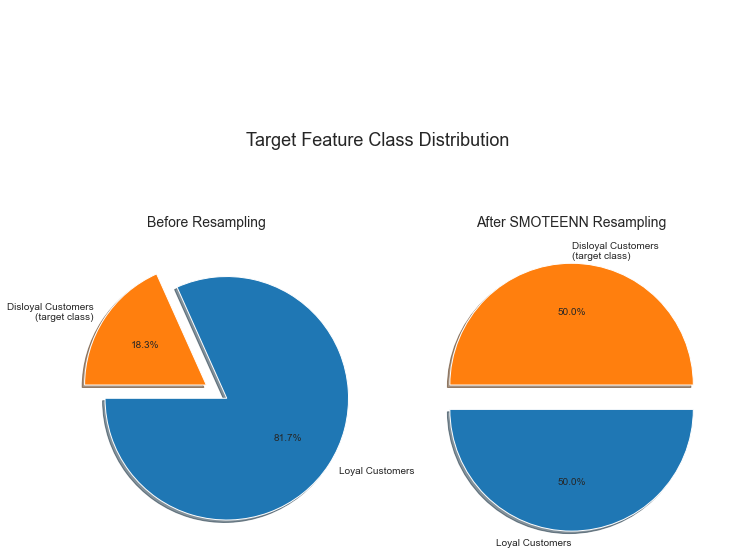

In [16]:
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
fig,axs = plt.subplots(1,2)
axs[0].pie([train_loyal_weight,train_disloyal_weight],
        labels=['Loyal Customers','Disloyal Customers\n(target class)'],
        startangle=180,
        shadow=True,
        explode=[.2,0],
        autopct='%1.1f%%')
axs[0].set_title("Before Resampling",fontsize=14)

axs[1].pie([resample_loyal_weight,resample_disloyal_weight],
        labels=['Loyal Customers','Disloyal Customers\n(target class)'],
        startangle=180,
        shadow=True,
        explode=[.2,0],
        autopct='%1.1f%%')
axs[1].set_title("After SMOTEENN Resampling",fontsize=14)

fig.suptitle("\n\n\n\n\n\nTarget Feature Class Distribution",fontsize=18)
fig.set_size_inches(12,11)
plt.subplots_adjust(wspace=0.2)
plt.show()

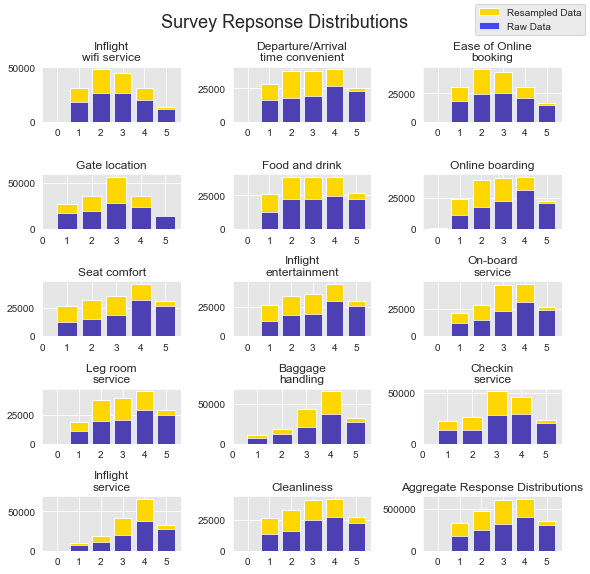

In [21]:
survey_df = X_train.iloc[:,2:16]
resample_survey_df = X_resample.iloc[:,2:16]

survey_labels = [
    'Inflight\nwifi service', 
    'Departure/Arrival\ntime convenient',
    'Ease of Online\nbooking', 
    'Gate location', 
    'Food and drink',
    'Online boarding', 
    'Seat comfort', 
    'Inflight\nentertainment', 
    'On-board\nservice', 
    'Leg room\nservice', 
    'Baggage\nhandling', 
    'Checkin\nservice', 
    'Inflight\nservice', 
    'Cleanliness']

fig, axes = plt.subplots(5,3)
row = 0
column = 0

for idx,col in enumerate(resample_survey_df.columns):

    raw = survey_df[col].value_counts().to_dict()
    resample = resample_survey_df[col].value_counts().to_dict()

    axes[row,column].bar(x=list(resample.keys()),height=list(resample.values()),color='gold')
    axes[row,column].bar(x=list(raw.keys()),height=list(raw.values()),color='blue',alpha=0.7)
    axes[row,column].set_title(survey_labels[idx])
    axes[row,column].set_xticks([0,1,2,3,4,5])

    column += 1 
    if column > 2:
        row += 1
        column = 0 

survey_count_dict = {1:0,2:0,3:0,4:0,5:0,0:0}
resample_survey_count_dict = {1:0,2:0,3:0,4:0,5:0,0:0}

for key in survey_count_dict.keys():
    survey_count_dict[key] += (survey_df.values==key).sum()
    resample_survey_count_dict[key] += (resample_survey_df.values==key).sum()

axes[4,2].bar(x=list(resample_survey_count_dict.keys()),height=list(resample_survey_count_dict.values()),color='gold')
axes[4,2].bar(x=list(survey_count_dict.keys()),height=list(survey_count_dict.values()),color='blue',alpha=0.7)
axes[4,2].set_title("Aggregate Response Distributions")
axes[4,2].set_xticks([0,1,2,3,4,5])

fig.set_size_inches(8, 8)
fig.suptitle("Survey Repsonse Distributions",fontsize=18)
fig.tight_layout()
fig.legend(loc='upper right',labels=['Resampled Data','Raw Data'])
plt.show()

In [27]:
X_resample.iloc[:,18:]

,Female,Male,Business travel,Personal Travel,Business,Eco,Eco Plus,neutral or dissatisfied,satisfied
0,0.000000,1.000000,0.0,1.0,0.0,0.00000,1.00000,1.000000,0.000000
1,0.000000,1.000000,1.0,0.0,1.0,0.00000,0.00000,1.000000,0.000000
2,1.000000,0.000000,1.0,0.0,1.0,0.00000,0.00000,0.000000,1.000000
3,1.000000,0.000000,1.0,0.0,1.0,0.00000,0.00000,1.000000,0.000000
4,0.000000,1.000000,1.0,0.0,1.0,0.00000,0.00000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...
169841,0.177810,0.822190,1.0,0.0,0.0,0.82219,0.17781,1.000000,0.000000
169842,0.866131,0.133869,1.0,0.0,0.0,1.00000,0.00000,0.133869,0.866131
169843,0.885372,0.114628,1.0,0.0,0.0,1.00000,0.00000,0.114628,0.885372
169844,0.518480,0.481520,1.0,0.0,1.0,0.00000,0.00000,1.000000,0.000000


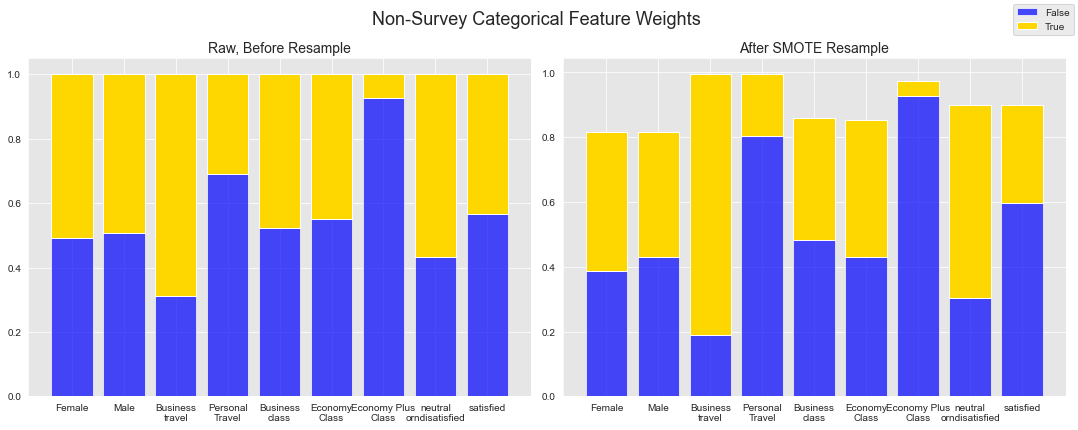

In [34]:
features = X_resample.iloc[:,18:].columns.values
labels = ['Female','Male','Business\ntravel','Personal\nTravel','Business\nclass','Economy\nClass','Economy Plus\nClass','neutral\norndisatisfied','satisfied']

raw_ones = []
raw_zeros = []

for idx,label in enumerate(labels):
    series = X_train[features[idx]].value_counts(normalize=True)
    raw_ones.append(series[1])
    raw_zeros.append(series[0])

resample_ones = []
resample_zeros = []

for idx,label in enumerate(labels):
    series = X_resample[features[idx]].value_counts(normalize=True)
    resample_ones.append(series[1])
    resample_zeros.append(series[0])   
    
# fig.set_size_inches(8, 8)
fig,axs = plt.subplots(1,2)
axs[0].bar(labels,raw_zeros,label='False',color='blue',alpha=.7)
axs[0].bar(labels,raw_ones,label='True',bottom=raw_zeros,color='gold')
axs[0].set_title('Raw, Before Resample',fontsize=14)

axs[1].bar(labels,resample_zeros,label='False',color='blue',alpha=.7)
axs[1].bar(labels,resample_ones,label='True',bottom=resample_zeros,color='gold')
axs[1].set_title('After SMOTE Resample',fontsize=14)

fig.legend(['False','True'])
fig.set_size_inches(15, 6)
fig.suptitle("Non-Survey Categorical Feature Weights",fontsize=18)
fig.tight_layout()
plt.show()

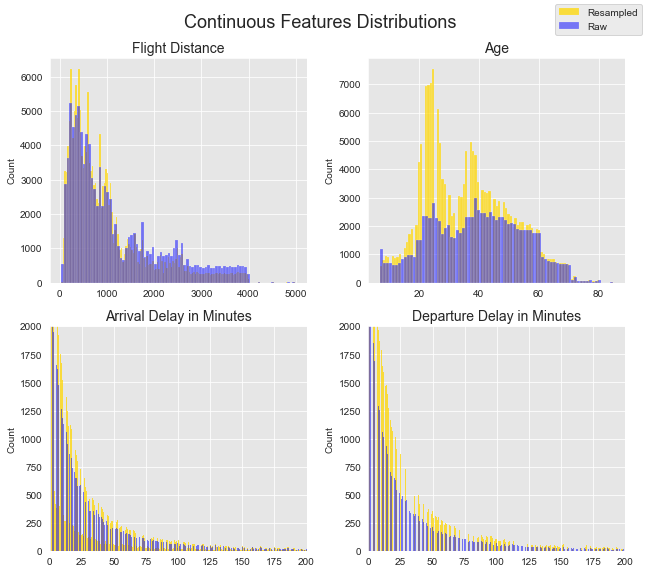

In [33]:
fig,axs = plt.subplots(2,2)

#Flight distance
ff = sns.histplot(data=X_resample['Flight Distance'],ax=axs[0,0],color='gold')
f = sns.histplot(data=X_train['Flight Distance'],ax=axs[0,0],color='blue',alpha=.5).set_title('Flight Distance',fontsize=14)
axs[0,0].set_xlabel("")

#age
aa = sns.histplot(data=X_resample['Age'],ax=axs[0,1],color='gold')
a = sns.histplot(data=X_train['Age'],ax=axs[0,1],color='blue',alpha=.5).set_title('Age',fontsize=14)
axs[0,1].set_xlabel("")

#Arrival Delay in Minutes
dede = sns.histplot(data=X_resample['Arrival Delay in Minutes'],ax=axs[1,0],color='gold')
de = sns.histplot(data=X_train['Arrival Delay in Minutes'],ax=axs[1,0],color='blue',alpha=.5).set_title('Arrival Delay in Minutes',fontsize=14)
axs[1,0].set_xlabel("")
axs[1,0].set_ylim(0,2000)
axs[1,0].set_xlim(0,200)

#Departure Delay in Minutes
dldl = sns.histplot(data=X_resample['Departure Delay in Minutes'],ax=axs[1,1],color='gold')
dl = sns.histplot(data=X_train['Departure Delay in Minutes'],ax=axs[1,1],color='blue',alpha=.5).set_title('Departure Delay in Minutes',fontsize=14)
axs[1,1].set_xlabel("")
axs[1,1].set_ylim(0,2000)
axs[1,1].set_xlim(0,200)

fig.suptitle("Continuous Features Distributions",fontsize=18)
fig.legend(['Resampled','Raw'])
fig.set_size_inches(9, 8)
fig.tight_layout()
plt.show()

### Tree-Based Model Development and Selection

After selecting a resampling strategy, my next step was to discover the optimal tree-based model and related hyper parameters. I performed this investigation in the [gridsearching notebook](./development/gridsearching.ipynb) found in the development/ folder of this repository, I discovered optimal hyperparameters using SciKit-Learn's [GridsearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) function and searching different grids in an iterative manner. After fitting each gridsearch I evaluated the optimized model against the test data, focusing primarily -again- on F1-score and ROC AUC. 

It turned out that the baseline Random Forest (sans hyperparameter tuning) was the strongest performer according to the F1-score. It should be noted that the computational expense of a gridsearch on a Random Forest on my machine was too great. So the Random Forest was not gridsearch but I experimented manually with some hyperparameters, using the best parameters found for the solo Decision Tree as a guideline. I found that any adjustments I made to the model only worsened its performance. The F1-score for the various tree-based models inspected is visualized below: 
![F1-Score Tree Based Models](./images/tree_based_f1scores.png)

The curve of the ROC AUC scores was quite acute, which made me suspicous of overfitting... however the confusion matrices associated with each model gave me some peace of mind in that regard. It should be noted that the following ROC curves are of the model's performance with the test data. Nonetheless, the trainin data set alone is over 150 thousand records, so at this point the ROC curves should be taken with a grain of salt. However the visualization below certainly demonstrates the models' performance relative to one another at least.  
![Tree-Based ROC curves](./images/tree_based_rocauc.png)

As a final attempt at validating that the Random Forest, with its default hyperparameter values, is in fact the highest performing model, I plotted the rate of correct and incorrect predictions by each model. The following visualization essentially shows how each model's confusion matrix compares to the others. Even here the basline Random Forest is the obvious best performer. Again, the following visualization represents each model's performance on the test data.  
![Prediction Performance](./images/tree_based_TF_rates.png)

## Final Model Performance Evaluation

In [35]:
# import dependencies
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import cross_val_score, cross_val_predict

In [36]:
# instantiate and fit model
RFC = RandomForestClassifier(n_jobs=3)
RFC.fit(X_resample,y_resample)

RandomForestClassifier(n_jobs=3)

### Evaluate Training Data Classification Report and Confusion Matrix

In [37]:
# evalute on training predictions
train_pred = cross_val_predict(RFC,X_train,y_train,n_jobs=3)
rfc_train_report = classification_report(y_train,train_pred,output_dict='true')
rfc_train_report = pd.DataFrame(rfc_train_report).iloc[:,0:3]
rfc_train_report

,0.0,1.0,accuracy
precision,0.987155,0.974602,0.984938
recall,0.994513,0.942100,0.984938
f1-score,0.990820,0.958075,0.984938
support,84923.000000,18981.000000,0.984938


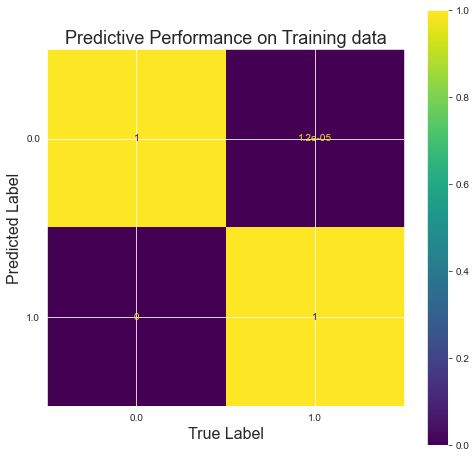

In [38]:
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(RFC,X_train,y_train,normalize='true',ax=ax)
ax.set_title("Predictive Performance on Training data",fontsize=18)
ax.set_xlabel('True Label',fontsize=16)
ax.set_ylabel('Predicted Label',fontsize=16)

plt.show()

The data used on the report and matrix above is the training sample *before* resampling. I also use the cross_val_predict() funciton in lieu of the more commonly used .predict() method to bolster the reliability of the predictions made. For this project I have been primarily concerned wit F1-score which scores extremely high here, but its worth noting that accuracy, precision and recall all individually score extremely high as well. 

### Evaluate Test Data Classification Report and Confusion Matrix

In [39]:
# evalute on test data
test_pred = cross_val_predict(RFC,X_test,y_test,n_jobs=3)
rfc_test_report = classification_report(y_test,test_pred,output_dict='true')
rfc_test_report = pd.DataFrame(rfc_test_report).iloc[:,0:3]
rfc_test_report

,0.0,1.0,accuracy
precision,0.982964,0.962248,0.979289
recall,0.991784,0.924151,0.979289
f1-score,0.987354,0.942815,0.979289
support,21177.000000,4799.000000,0.979289


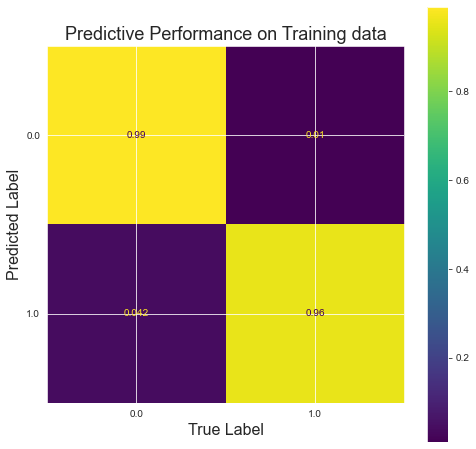

In [40]:
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(RFC,X_test,y_test,normalize='true',ax=ax)
ax.set_title("Predictive Performance on Training data",fontsize=18)
ax.set_xlabel('True Label',fontsize=16)
ax.set_ylabel('Predicted Label',fontsize=16)

plt.show()

Test data results are extremely consistent with training data results. So this model is incredibly strong in the sense that it is compatible with a variety of classification tasks that may prioritize any one of the performance metrics (accuracy, F1-score, precision, recall)

#### Train vs Test ROC AUC

In [41]:
# Calculate the fpr, tpr, and thresholds for the training set
train_fpr , train_tpr, train_thresholds = roc_curve(y_train, train_pred)
train_auc = auc(train_fpr, train_tpr)
print('RFC train AUC: {}'.format(train_auc))

# Calculate the fpr, tpr, and thresholds for the testing set
test_fpr , test_tpr, test_thresholds = roc_curve(y_test, test_pred)
test_auc = auc(test_fpr, test_tpr)
print('RFC test AUC: {}'.format(test_auc))

RFC train AUC: 0.968306335460296
RFC test AUC: 0.9579672017541786


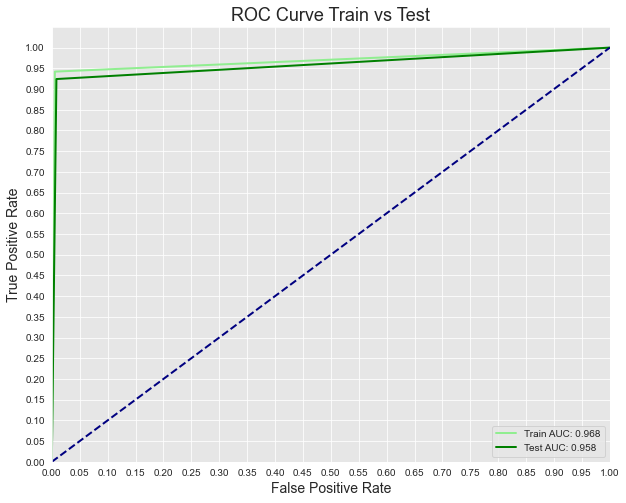

In [42]:
plt.figure(figsize=(10,8))
lw = 2

plt.plot(train_fpr, train_tpr, color='lightgreen',
         lw=lw, label=f'Train AUC: {round(train_auc,3)}')
plt.plot(test_fpr,test_tpr,color='green',
         lw=lw, label=f'Test AUC: {round(test_auc,3)}')

# Formatting
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.title('ROC Curve Train vs Test',fontsize=18)
plt.legend(loc="lower right")
plt.show()

ROC curves are known to be somewhate unreliable with large amounts of data like this project utilizes, nonetheless I felt is was worth plotting. Not much being told here that we don't alreadu know from the classification reports and confusion matrices.

# Model Interpretation and Business Recomendations

I conducted a thorough descriptive analysis of the data based on the model's feature importance rankings. The full analysis is annotated in the final section of the [gridsearch notebook](./development/gridsearching.ipynb), all the code used to render plots and massage the data into plottable formates is available there as well. Therefore, here I will be linking the graphs from that notebook and sumarizing my analysis and discoveries. 

#### Feature Importance

In [43]:
# zip feature labels and importances into a dict
feature_importance_dict = {t[0]:t[1] for t in list(zip(X_train.columns.values,RFC.feature_importances_))}
# sort the dict by value
feature_importance_dict = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1],reverse=True))

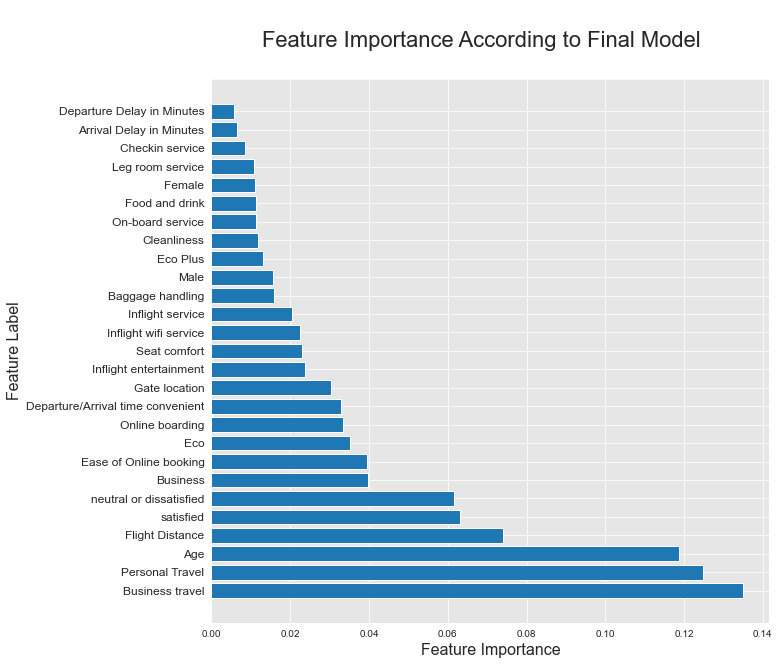

In [44]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(10,10))
    plt.barh(range(len(feature_importance_dict.keys())), list(feature_importance_dict.values()), align='center') 
    plt.yticks(np.arange(n_features),list(feature_importance_dict.keys()),fontsize=12) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(RFC)
plt.suptitle("\nFeature Importance According to Final Model",fontsize=22)
plt.xlabel('Feature Importance',fontsize=16)
plt.ylabel('Feature Label',fontsize=16)
plt.show()

Instead of linking the .png file I actually plotted the feature importances of the model object in this notebook, just to validate that the model is consistent accross instances in other notebooks. The plot above is identical to the one in the original gridsearching notebook.  

Obviously Age of the customer, their purpose for travel (business/personal), the overall satisfaction of the customer (satisfied/disatisfied), as well as the distance of the flight were the features the model relies on the most when making a prediction on the loyalty of the customer. 

Interstingly the class of ticket (economy/business/economy plus), as well as arrival/departure delays, and check-in service are the least important factors to the model. 

Looking strictly at the survey response features, the most important are the online services relates to check-in (online boarding, online booking), factors regarding the airport itself and the itenerary (parture/arival time convenience and gate location), and factors regarding inflight comfort (wifi, leg room, food/drink and entertainment). Those aformentioned features will be the focus of the descriptive analysis to discover patterns that may inform us as to what aspects of the customer experience of disloyal customers needs to be improved the most. 

#### Age vs Flight Distance vs Boolean Features

My first step after evaluating the feature importances was to cross reference the Age and Flight Distance with the other most important boolean features. Note that gender here is plotted mostly just to fill in what would be an awkward blank square. I decided to focus my analysis on the clusters outlined in red. Because these appear to be the areas with the greatest density of disloyal customers (the target of this analysis).    
<img src=./images/age_vs_distance_marked.png width=700>

The scatter plots above gave me a clue as to what clusters of the data to focus on, but it didn't give me a hint as to how flight distance and/or age realtes to customer satisfaction nor how that might differ between loyal and disloyal customers. So I made the following bar charts to discover any such relationships.  
<img src=./images/age_distance_loyalty_satisfaction.png width=1100>

For both age and flight distance the upper quartile of disatisfaction (in terms of volume) constitutes roughly the lower half of the range of the respective feature. In other words the most disatisfaction is found in the first and second quartiles of age and flight distance. Some of this may be due to relative scarcity of data for the more extreme ranges. Unsiprisingly, disloyal customers are the most disatisfied, especially at the lower ranges of age and flight distance.

It is unlikely that improving satisfaction for flyers under 16 would have any real impact on loyalty conversion save for their satisfaction being a proxy to the parents satisfaction, which can not be made clear from this data. 

It is clear however that there is the bulk of disatisfaction to be addressed can be found on flights udner ~2500 miles and individuals under ~45.

Satisfaction, a boolean featuer where 1 represents an overall satisfied customer, is one of the most important features for the model, however it is certainly a proxy to the aggregate satisfaction of a customers survey responses, some of which were fairly important themselves. So I built the following plot in order to examine the relationship between overall customer satisfaction as a boolean value and aggregate customer satsifaction for each survey question as an ordinal categorical value (1-5).  

<img src=./images/loyal_vs_disloyal_satisfaction.png width = 1200>

Again, unsuprisingly there is far more disatisfaction found within the disloyal sector of the market. Although there is more disatisfaction by volum from disloyal customers, the degree of disatisfaction for one survey question relative to the others is fairly consistent between loyal and disloyal customers.  

Baggage handling and inflight wifi service share the greatest portion of disatisfaction. Baggage handling was not an outstandingly important feature to the model, however inflight wifi service was fairly important. Leg-room, another fairly important feature also shares a large portion of the disatisfaction held by the disloyal customers. Food and drink as well as inflight entertainment deserve attention here as well. 

I also wanted to evaluate customer satisfaction per survey response constrained to the clusters outlined in the scatter plot above, as well as for business travel since it generally overlaps with those age/flight distance clusters. 

fig. 1|fig. 2
-|-
<img src=./images/disloyal_market_share.png height=700 width=300>|<img src=./images/disloyal_survey.png height=700 width=900>

In the above visualization, fig. 1 on the left shows the market share of each group represented, and fig. 2 on the right shows that groups aggregate survey responses (i.e. each feature is summed, bar height represents sum total of responses). Red represents the bottom quartile of response for that groop, green represents the fourth quartile, and yellow represents the second and third quartiles.  

Judging by market share alone, efforts to improve satisfaction to senior citizens would have little impact, if even noticeable, its advisable to focus efforts on the groups represented by the top and bottom charts here. 

Of the survey questions alone, online boarding is the most important feature. Business travelers as well as young adults scored this feature in the first quartile of responses (extremely poorly) and seniors scored it still no higher than third quartile.

Inflight wifi, and ease of online booking were also extremely important to the model, and customers accross the board scored these features in the bottom quartile, along with departure/arrival times which were also relatively important to the model.  

Business travelers and young adults are generaly not thrilled with the food and drink, seat comfort, cleanliness, and inflight entertainment, as well as gate location. 

# Final Recommendations

I recommend focusing efforts to improve satisfaction of customer experience for individuals traveling for business purposes and/or between the ages of 16 and 40, for flights 3000 miles or less.  

Specific aspects of the customer experience on those flights that I predict will have the greatest return on efforts made are the customer's online experience (online booking, online boarding), internet dependent in-flight services such as wifi, and entertainment, and comfort related features of the flight itself such as seat comfort, food and drink, and overall cleanliness. 

Improving gate location as well as the convenience of the departure and arrival times would have a great impact according to my analysis of the data, however I do not believe it would be economical to implement changes here because it would require significant coordination and concession by and width other airlines as well as the FAA. 

It is best to focus on improving inflight services like wifi and entertainment, refreshments and seat comfort, and the UX of pre-boarding online services for business flights and youn adults flying less than 3000 miles. 